In [1]:
# ========================
# DenseNet121 - BRISC 2025 Classifier
# ========================

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import pickle

# === Data Augmentation ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.2,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    './archive/brisc2025/classification_task/train',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    './archive/brisc2025/classification_task/train',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    './archive/brisc2025/classification_task/test',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# === Callbacks ===
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('./models/best_densenet121_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# === Base Model ===
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# === Custom Classifier ===
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

# === Compile ===
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# === Summary ===
model.summary()

# === Train ===
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

2026-02-02 10:47:52.137761: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-02 10:47:52.141576: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-02 10:47:52.342388: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-02 10:47:53.487311: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Found 3402 images belonging to 4 classes.
Found 849 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


E0000 00:00:1770009476.890629    9449 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1770009476.895356    9449 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


26542080/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

KeyboardInterrupt: 

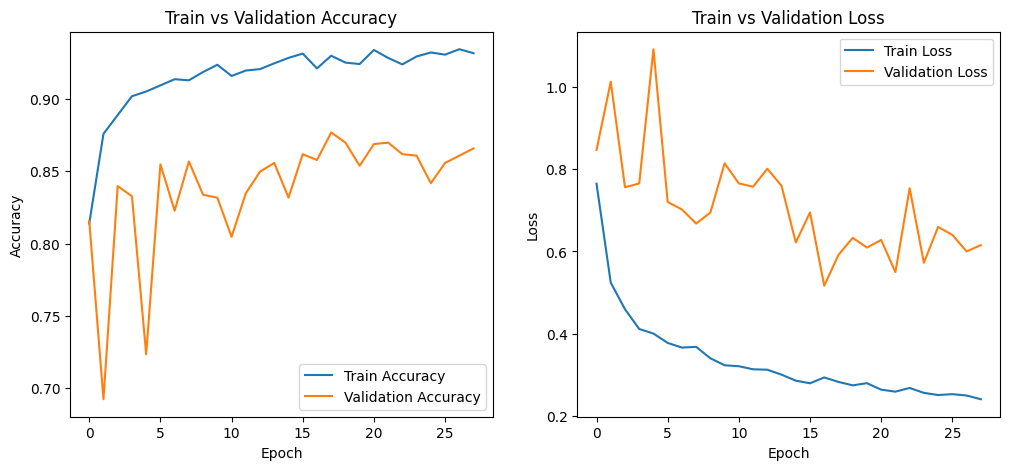

In [2]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.show()


In [3]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_generator)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.classes


32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 921ms/step


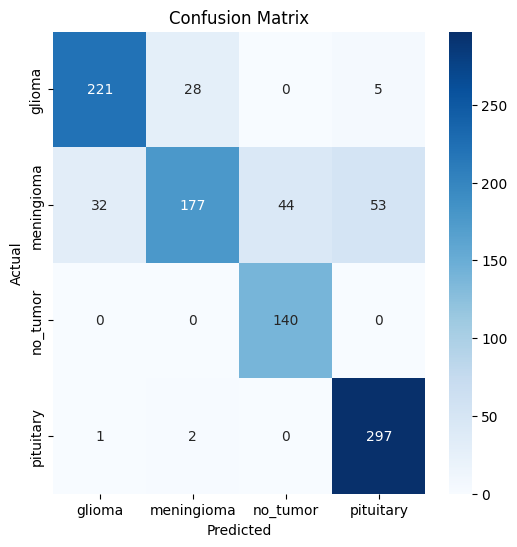

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Test Accuracy: {accuracy*100:.2f}%')
print(f'Test Precision: {precision*100:.2f}%')
print(f'Test Recall: {recall*100:.2f}%')
print(f'Test F1 Score: {f1*100:.2f}%')

# Detailed per-class report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

Test Accuracy: 83.50%
Test Precision: 84.02%
Test Recall: 83.50%
Test F1 Score: 82.52%

Classification Report:

              precision    recall  f1-score   support

      glioma       0.87      0.87      0.87       254
  meningioma       0.86      0.58      0.69       306
    no_tumor       0.76      1.00      0.86       140
   pituitary       0.84      0.99      0.91       300

    accuracy                           0.83      1000
   macro avg       0.83      0.86      0.83      1000
weighted avg       0.84      0.83      0.83      1000

